# Tutorial for the autoCBH package

In [1]:
# add autocbh package to path
import sys
sys.path.append('../autocbh')

# import relevant rdkit 
from rdkit import Chem
# drawing tools used for CBH.buildCBH visualization
from rdkit.Chem import Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from IPython.display import SVG, display

# Import CBH generator
from CBH import buildCBH
from calcCBH import calcCBH
from TN import thermochemical_network, visualize
from UQ import uncertainty_quantification

# only needed for np.inf example for now
import numpy as np
from numpy import inf
import pandas as pd

# autoCBH directory structure

```
autoCBH
├── autocbh/
│   ├── data/
│   │   ├── molData.py
│   ├── CBH.py
│   │   ├── [class] buildCBH 
│   ├── calcCBH.py
│   │   ├── [class] calcCBH
│   ├── hrxnHelpers.py
│   ├── TN.py
│   │   ├── [class] thermochemical_network
│   │   ├── [func] visualize
│   ├── UQ.py
│   │   ├── [class] thermochemical_network
├── data/
│   ├── *data/
│   ├── *.yaml
├── examples/
│   ├── *.ipynb  (you are here)
```

# CBH Module
Main module which is used to generate CBH schemes. It contains the $\texttt{buildCBH}$ class which is the true driver. It generates cbh reactants and products in separate dictionaries assuming target molecule has stoichiometric coefficient = 1:

```
buildCBH.cbh_rcts = {cbh_rung [int] : {cbh_product [str] : reference_coeff [int/float] } }
buildCBH.cbh_pdts = {cbh_rung [int] : {cbh_reactant [str] : reference_coeff [int/float] } }
```

### Propane CBH example
Let's start with a simple example: propane (smiles string = 'CCC') with hydrogenated saturation.

In [2]:
cbh = buildCBH(smiles='CCC', 
               # below are optional with defaults
               saturate='H', # default = 1 --> can use string version of element (i.e., 'H' is the same as the int 1)
               allow_overshoot=False, # default = False 
               ignore_F2=True, # default = True
               surface_smiles=None) # default = None

You can access important attributes such as the reactants and products. We see that there are only 2 CBH rungs.

In [3]:
cbh.cbh_rcts, cbh.cbh_pdts

({1: {'C': 1}, 0: {'[H][H]': 2.0}}, {0: {'C': 3}, 1: {'CC': 2}})

Let's visualize this


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


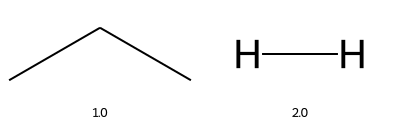


Products:


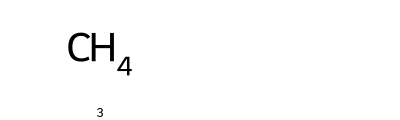


-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


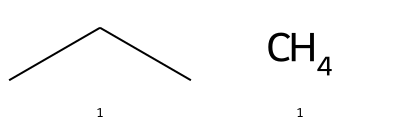


Products:


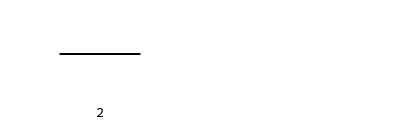

In [4]:
cbh.visualize()
# you can specify specific rungs you want by giving an [int] as an argument (i.e., cbh.visualize(1) --> CBH-1)
# if you give it '-1' you'll get the highest rung

### Fluorinated Species Example
Let's try some PFAS species: GenX

In [5]:
# RDKit's Chem module has useful functions like rdkit.Chem.MolFromSmiles() to get molecule object from a smiles string
# rdkit.Chem.CanonSmiles() is also used throughout the package to get the canonical smiles string

genx = 'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)(F))C(F)(F)(F)'
Chem.CanonSmiles(genx)

'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F'

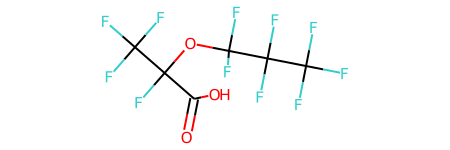

In [6]:
Chem.MolFromSmiles(genx)

In [7]:
cbh = buildCBH(genx, 
               'F', # can use the [int]: 9
               allow_overshoot=True, # not relevant here
               ignore_F2=True, # CBH-0 will not include F2 and instead use a reaction dependent on CF4
               surface_smiles=None # not relevant here
              )
'CBH RCTS:', cbh.cbh_rcts, 'CBH PDTS:', cbh.cbh_pdts

('CBH RCTS:',
 {1: {'FC(F)(F)F': 6, 'O': 1},
  0: {'[H][H]': 9.0},
  2: {'FC(F)(F)C(F)(F)F': 2, 'OC(F)(F)F': 2},
  3: {'OC(F)(F)C(F)(F)F': 1,
   'OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)F': 1},
  4: {'FC(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1, 'FC(F)(F)OC(F)(F)C(F)(F)F': 1},
  5: {'FC(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1}},
 'CBH PDTS:',
 {0: {'C': 3.25, 'O': 3, 'FC(F)(F)F': 2.75},
  1: {'OC(F)(F)F': 3, 'O=C(F)F': 1, 'FC(F)(F)C(F)(F)F': 4},
  2: {'O=C(O)C(F)(F)F': 1,
   'OC(F)(F)C(F)(F)F': 1,
   'OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)C(F)(F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)F': 1},
  3: {'OC(F)(F)C(F)(F)C(F)(F)F': 1,
   'O=C(O)C(O)(F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)C(F)(F)F': 1},
  4: {'O=C(O)C(F)(OC(F)(F)F)C(F)(F)F': 1,
   'FC(F)(F)OC(F)(F)C(F)(F)C(F)(F)F': 1,
   'FC(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1},
  5: {'FC(F)(F)C(F)(F)C(F)(F)OC(F)(C(F)(F)F)C(F)(F)F': 1,
   'O=C(O)C(F)(OC(F)(F)C(F)(F)F)C(F)(F)F': 1}})


-----------------------------------------------------------------------------------------------------

CBH RUNG 5

Reactants:


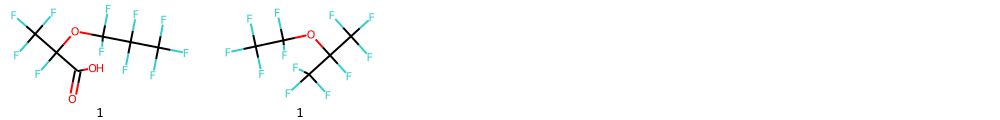


Products:


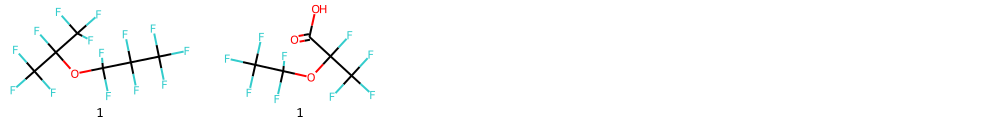

In [8]:
cbh.visualize(-1)

### Examples of allow_overshoot and ignore_F2

##### 1) allow_overshoot
Molecule = CH$_3$CF$_2$CH$_3$

If you 'overshoot' this, you will generate C$_3$F$_8$, which is a larger molecule.
Sometimes you want this since you might have experimental values for C$_3$F$_8$, but not for CH$_3$CF$_2$CH$_3$.
Allowing overshoot in this case will let you use this experimental value and thus use a more accurate CBH rung.




-----------------------------------------------------------------------------------------------------

CBH RUNG 3

Reactants:


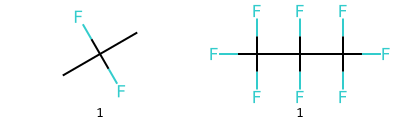


Products:


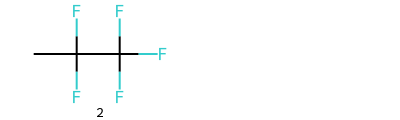

In [9]:
# allow overshoot (default)
buildCBH('CC(F)(F)C', 9, allow_overshoot=True).visualize(-1)


-----------------------------------------------------------------------------------------------------

CBH RUNG 1

Reactants:


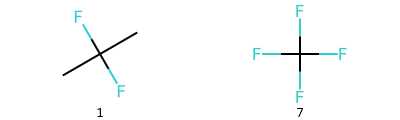


Products:


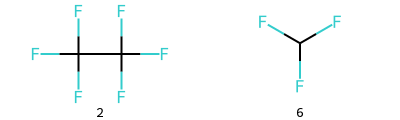

In [10]:
# disallow overshoot
buildCBH('CC(F)(F)C', 9, allow_overshoot=False).visualize(-1)

##### 2) ignore_F2
This only applies to CBH-F-0 and doesn't affect higher CBH rungs. 

This uses the following formula instead of the classical CBH-F-0 rung that would use F$_2$ as a reactant. 
In other words, the formula uses CF$_4$ to balance fluorine atoms rather than F$_2$.

$(a - \frac{c}{4})\text{CH}_4 + b\text{H}_2\text{O} + \frac{c}{4}\text{CF}_4 + (\frac{d}{2} - 2a - b + \frac{c}{2})\text{H}_2 --> \text{C}_a\text{O}_b\text{F}_c\text{H}_d$


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


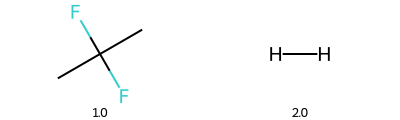


Products:


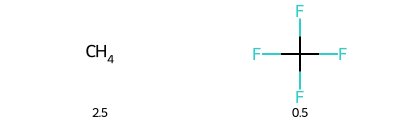

In [11]:
# don't use F2 in CBH-F-0 (default and preferred)
buildCBH('CC(F)(F)C', 9, ignore_F2=True).visualize(0)


-----------------------------------------------------------------------------------------------------

CBH RUNG 0

Reactants:


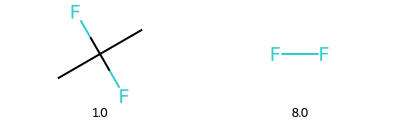


Products:


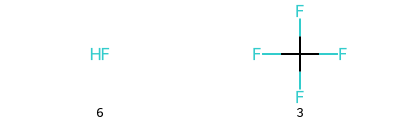

In [12]:
# use F2 in CBH-F-0
buildCBH('CC(F)(F)C', 9, ignore_F2=False).visualize(0)

# TN Module
## Thermochemical Network
It is useful to generate a thermochemical network initially to see what species you might need to compute. You are restricted by the number of QM levels of theory that are available to you as higher CBH rungs are linear combinations of lower ones so you likely will not be able to use the highest CBH rungs for large molecules. Nonetheless, it is useful to help plan what species' energies you need to compute.

In [13]:
tn = thermochemical_network([genx, 'FC(F)(F)OC(F)C(F)(F)F'], 
                       max_rung=inf, # can set max rung (default = np.inf)
                       saturate=1, # same rules as before
                       surface_smiles=None) # doesn't apply here

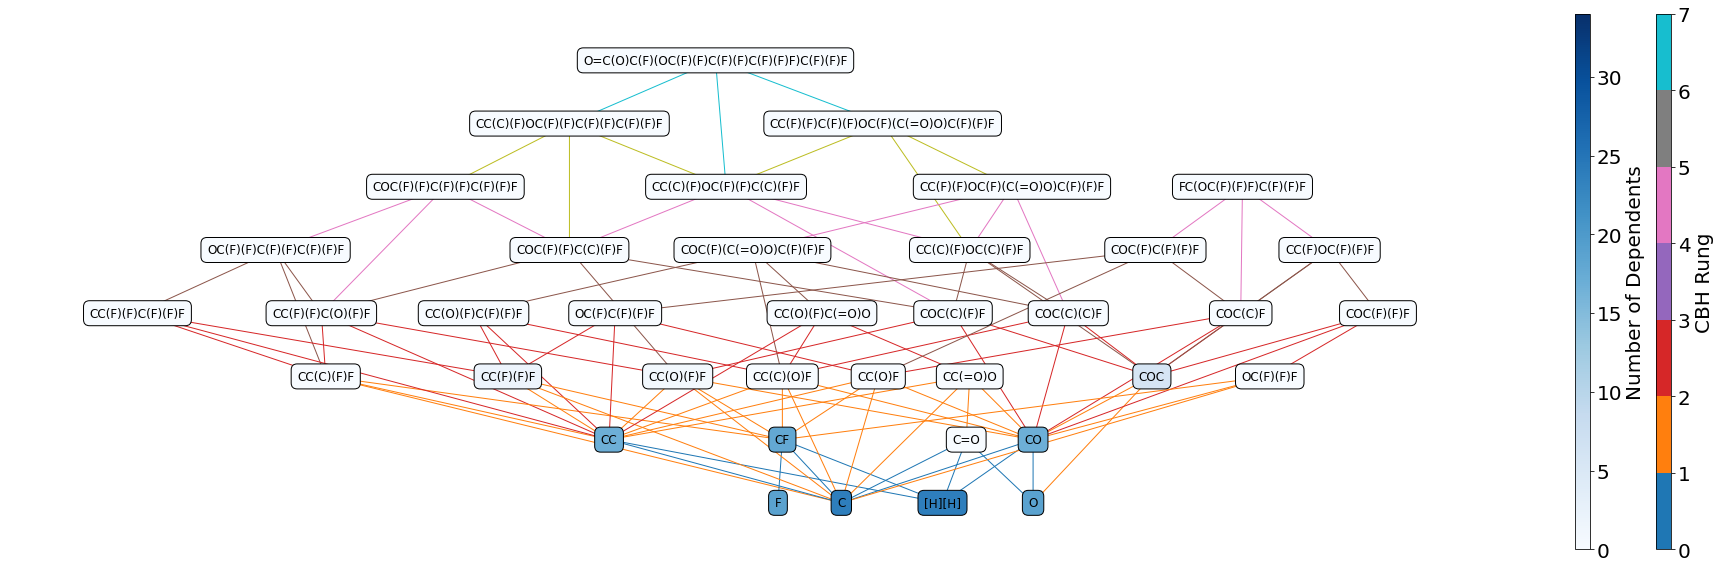

In [14]:
# this method is a wrapper for the TN.visualize function
# both can visualize any networkx graph you want
tn.visualize() # There are a lot of arguments you can use...but there are so many settings might get annoying

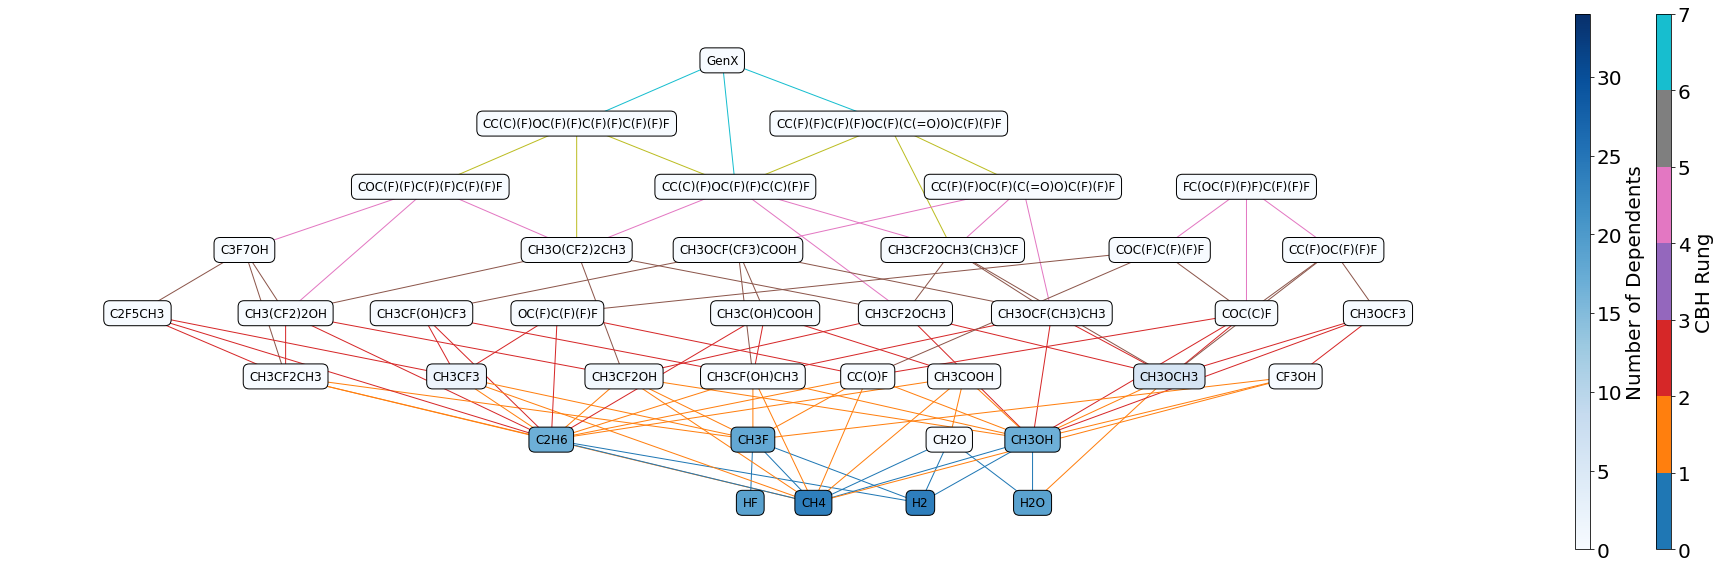

In [15]:
# SMILES strings are annoying to read. If you give it a yaml file or a dictionary holding a mapping of smiles
# strings to/from names you like, it can be easier 
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', 
             reverse_relabel_node_mapping=True)

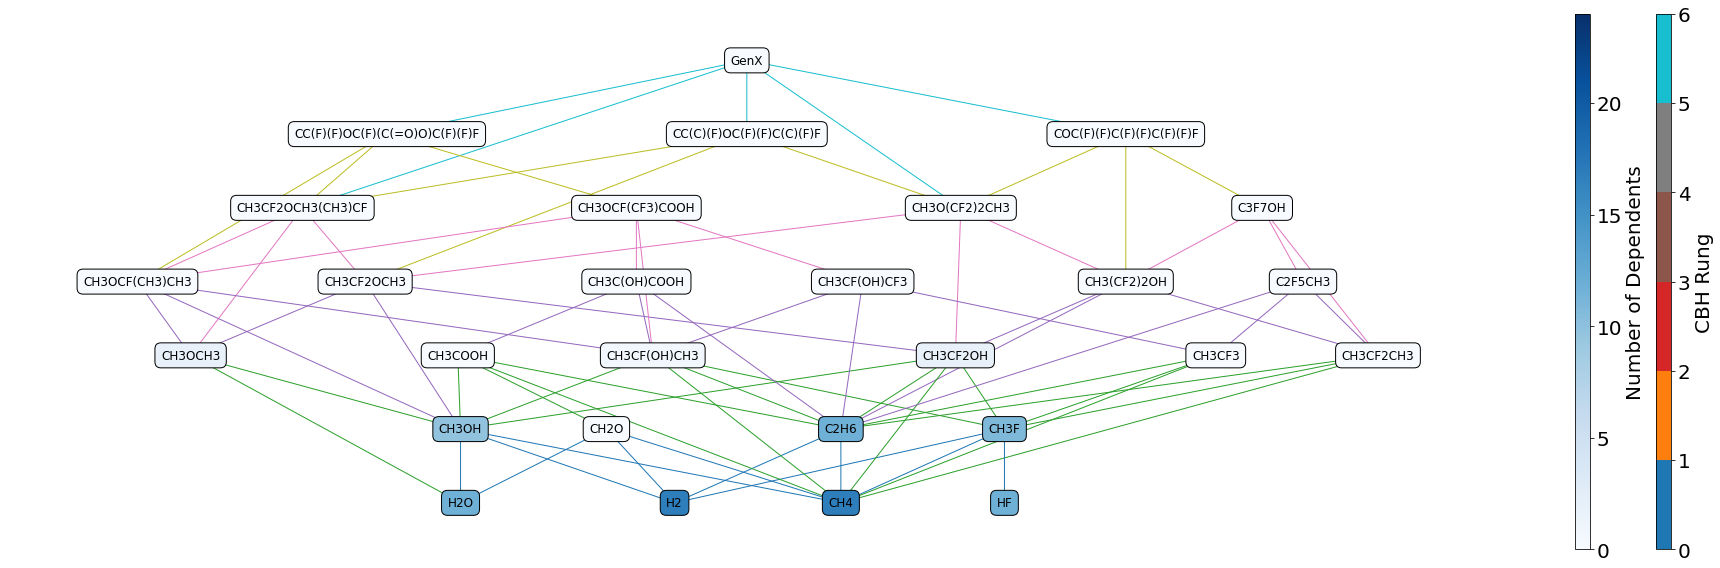

In [16]:
# It's unlikely we go higher than say CBH-5-H (this is just a guess for example)
# lets visualize that
# there are some bugs with the color scheme.............
tn = thermochemical_network(genx, 
                       max_rung=5, # can set max rung (default = np.inf)
                       saturate=1, # same rules as before
                       surface_smiles=None) # doesn't apply here
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', 
             reverse_relabel_node_mapping=True)

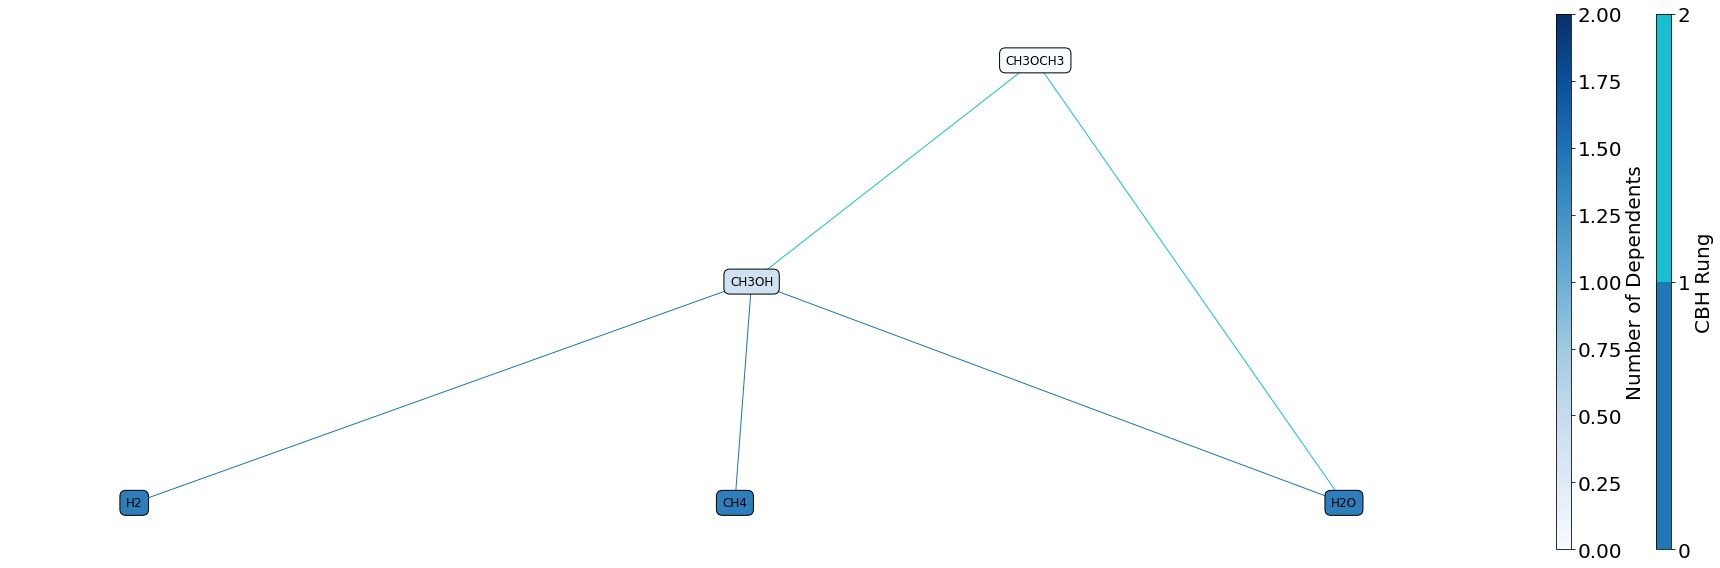

In [17]:
# We can also visualize subgraphs easily (i.e., CH3OCH3)
visualize(tn.descendent_subgraph_of('COC'),
          relabel_node_mapping='../data/alias_manual_2.yaml', 
          reverse_relabel_node_mapping=True)

# calcCBH Module
Now let's actually start calculating heats of formation.

Three seperate files are required.
1. A database structured to format to a Pandas dataframe (autoCBH supports a pickled dictionary or specifically formated YAML files for each molecule). The data that MUST be in these files for every given molecule are:
    - SMILES string representation
    - QM energy keyword and corresponding energy in HARTREE/mol
2. A YAML file that maps energy keywords to the specific type of QM method
3. A YAML file containing a mapping from QM methods to a numerical rank

For these examples, data is found at : "../autocbh/data/pfas_energies.pkl"

In [18]:
# Initialize module
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            alternative_rxn_path=None, # if you have alternative reactions you want to use (default=None)
            force_generate_database=None, # we don't do this since we already give a dataframe, but can make a df using a molecular database
            force_generate_alternative_rxn=None, # we don't do this here
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan

Loaded database contains 73 species.


The 'calcCBH.energies' attribute holds the dataframe used to compute and store heats of formation. At the beginning, all species with unknown heats of formation must start with the following:
- 'DfH' column set to 0.0
- 'DrxnH' column set to 0.0
- 'source' column set to NaN (np.nan)

If desired, this can be done with the 'zero_out_heats' keyword argument.

In [19]:
c.energies # what dataframe looks like initially

,avqz,av5z,zpe,ci_DK,ci_NREL,core_0_tz,core_X_tz,core_0_qz,core_X_qz,ccT,...,m062x_zpe,m062x_E0,m062x_dlpno,wb97xd_zpe,wb97xd_E0,wb97xd_dlpno,DfH,uncertainty,source,DrxnH
F,-100.374607,-100.385414,0.009516,-100.418439,-100.336980,-100.399909,-100.343580,-100.438007,-100.375659,-100.228149,...,0.009519,-100.438867,-100.377249,0.009499,-100.446863,-100.377250,-272.680000,0.019000,ATcT,0.000000
O,-76.361486,-76.369349,0.021537,-76.374215,-76.325214,-76.389795,-76.335691,-76.420950,-76.361296,-76.241167,...,0.021458,-76.385727,-76.363501,0.021458,-76.385727,-76.363501,-238.898000,0.025000,ATcT,0.000000
[H][H],-1.173800,-1.174223,0.010044,-1.172645,-1.172636,-1.172337,-1.172337,-1.173796,-1.173796,-1.163447,...,0.010179,-1.158688,-1.173901,0.010105,-1.166498,-1.173906,0.000000,0.000000,ATcT,0.000000
C,-40.450902,-40.454546,0.044805,-40.439335,-40.425254,-40.488984,-40.439118,-40.505899,-40.451355,-40.387070,...,0.044982,-40.456434,-40.451844,0.044881,-40.474939,-40.451847,-66.551000,0.048000,ATcT,0.000000
CF,-139.604415,-139.618802,0.039489,-139.622789,-139.527270,-139.670116,-139.564240,-139.722928,-139.606438,-139.407026,...,0.039685,-139.699152,-139.607852,0.039427,-139.715731,-139.607844,-227.480000,0.230000,ATcT,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.094113,-1864.282055,-1862.658045,0.091895,-1864.309509,-1862.657796,0.000000,NaN,NaN,0.000000
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.152474,-1506.531569,-1505.243417,0.150776,-1506.574464,-1505.243325,0.000000,NaN,NaN,0.000000
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.129663,-1804.304461,-1802.743266,0.127537,-1804.340926,NaN,0.000000,NaN,NaN,0.000000
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.116481,-1953.569792,-1951.843852,0.114229,-1953.598445,-1951.843678,0.000000,NaN,NaN,0.000000


In [20]:
c.methods_keys_dict

{'anl0': ['av5z',
  'core_X_qz',
  'core_0_qz',
  'core_X_tz',
  'ci_DK',
  'ccT',
  'core_0_tz',
  'zpe_harm',
  'avqz',
  'zpe',
  'ci_NREL',
  'ccQ',
  'zpe_anharm'],
 'b2plypd3': ['b2plypd3_E0'],
 'f12b': ['b2plypd3_zpe', 'f12b'],
 'm062x': ['m062x_E0'],
 'm062x_dlpno': ['m062x_zpe', 'm062x_dlpno'],
 'wb97xd': ['wb97xd_E0'],
 'wb97xd_dlpno': ['wb97xd_zpe', 'wb97xd_dlpno']}

In [21]:
c.rankings

{1: ['ATcT', 'exp'],
 2: ['anl0'],
 3: ['f12b'],
 4: ['m062x_dlpno', 'wb97xd_dlpno'],
 6: ['b2plypd3'],
 7: ['m062x', 'wb97xd']}

In [22]:
# calc_Hf method modifies the calcCBH.energies dataframe attribute in place and outputs a portion of the full df

c.calc_Hf(saturate=[1], # only use CBH-H
          priority='abs_coeff', # only useful if you use multiple saturations or add in alt_rxns
          max_rung= None, # can choose a maximum rung, otherwise will do highest possible
          alt_rxn_option=None,
          surface_smiles=None)

Process completed with errors in 23 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3357.674522,1.715739,CBH-4-H//m062x_dlpno+wb97xd_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2589.115325,7.878635,CBH-4-H//m062x_dlpno+wb97xd_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3175.827851,3.287536,CBH-4-H//m062x_dlpno
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3456.327253,1.383071,CBH-4-H//m062x_dlpno+wb97xd_dlpno


In [23]:
# print any errors or reasoning for not using best level of theory
c.print_errors()

O=C(O)C(F)(F)F:

	This species was decomposed from CBH-2-H to be made up of species from CBH-H: ['1', '2']
	Beware that the logged rungs may not be fully representative. 
	They are drawn only from comparing reference species to this specific saturation scheme.
	It is possible that the decomposed reaction contains higher or lower rungs from other saturation schemes.
	Check self.rxns attribute for accurate representation.


OC(F)(C(F)(F)F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-2-H.
	Moving down to CBH-2-H.


O=C(O)C(O)(F)C(F)(F)F:

	All precursor species for CBH-3-H had the same level of theory. 
	The reaction was decomposed into each precursors' substituents which was found to be equivalent to CBH-2-H.
	Moving down to CBH-2-H.


OC(F)(F)C(F)(F)C(F)(F)F:

	This species was decomposed from CBH-3-H to be made up of species from CBH-H: ['2', '3']
	Bew

#### Print decomposed reactions

For each molecule, the chosen CBH rung is decomposed down to its basic reference species that use a more accurate QM method. The 'rxns' attribute holds the broken down reaction dictionaries that were used in the calculation of these heats of formation.

In [24]:
c.rxns

{'OC(F)(F)F': {'H': {'CO': 1, 'CF': 3, 'C': -3}},
 'CC(F)(F)F': {'H': {'CC': 1, 'CF': 3, 'C': -3}},
 'CC(O)(F)F': {'H': {'CO': 1, 'CF': 2, 'CC': 1, 'C': -3}},
 'COC(F)(F)F': {'H': {'COC': 1, 'OC(F)(F)F': 1, 'CO': -1}},
 'O=C(O)C(F)(F)F': {'H': {'CC(=O)O': 1, 'CF': 3, 'C': -3}},
 'OC(F)(F)C(F)(F)F': {'H': {'CC(F)(F)F': 1, 'CC(O)(F)F': 1, 'CC': -1}},
 'CC(C)(F)F': {'H': {'CC': 2, 'CF': 2, 'C': -3}},
 'CC(C)(O)F': {'H': {'CO': 1, 'CF': 1, 'CC': 2, 'C': -3}},
 'FC(F)(F)OC(F)(F)F': {'H': {'COC(F)(F)F': 2, 'COC': -1}},
 'CC(F)(F)C(F)(F)F': {'H': {'CC(C)(F)F': 1, 'CC(F)(F)F': 1, 'CC': -1}},
 'CC(O)(F)C(F)(F)F': {'H': {'CC(F)(F)F': 1, 'CC(C)(O)F': 1, 'CC': -1}},
 'FC(F)(F)C(F)(F)C(F)(F)F': {'H': {'CC(F)(F)C(F)(F)F': 2, 'CC(C)(F)F': -1}},
 'OC(F)(C(F)(F)F)C(F)(F)F': {'H': {'CC(C)(O)F': 1, 'CC(F)(F)F': 2, 'CC': -2}},
 'COC(C)(F)F': {'H': {'CC(O)(F)F': 1, 'COC': 1, 'CO': -1}},
 'CC(F)(F)C(=O)O': {'H': {'CC(C)(F)F': 1, 'CC(=O)O': 1, 'CC': -1}},
 'CC(O)(F)C(=O)O': {'H': {'CC(=O)O': 1, 'CC(C)(O)F': 

In [25]:
c.rxns['FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F']

{'H': {'CC(F)(F)C(F)(F)C(F)(F)F': 2,
  'CC(F)(F)C(F)(F)C(C)(F)F': 4,
  'CC(F)(F)C(C)(F)F': -5}}


-----------------------------------------------------------------------------------------------------

CBH RUNG 4

Reactants:


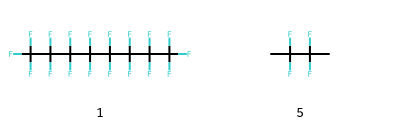


Products:


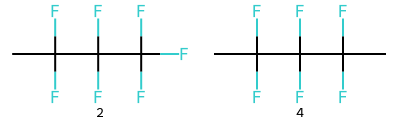

In [26]:
buildCBH('FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F').visualize(4)

### Only using some lower level QM methods
When we only use low level QM method: DLPNO//M062X, we see that we are limited to only using low CBH levels due to lack of large molecules with high accuracy.

In [27]:
# Initialize module
c = calcCBH(methods=['m062x_dlpno'], # CHANGED
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan

Loaded database contains 73 species.


In [28]:
c.methods_keys_dict

{'m062x_dlpno': ['m062x_zpe', 'm062x_dlpno']}

In [29]:
c.calc_Hf(saturate=[1, 9], # only use CBH-H
          max_rung= None, # can choose a maximum rung, otherwise will do highest possible
          alt_rxn_option=None, 
          priority='rel_coeff', # uses weighted average of both H and F CBH schemes if applicable
          surface_smiles=None)

Process completed with errors in 50 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3372.697205,14.120240,"CBHavg-(1-H, 1-F)//m062x_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2597.120519,358.868628,"CBHavg-(1-H, 1-F)//m062x_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3188.487947,225.560304,"CBHavg-(1-H, 1-F)//m062x_dlpno"
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3469.322661,3.876026,"CBHavg-(1:2-H, 0:2-F)//m062x_dlpno"


In [30]:
c.print_errors()

CC(O)(F)F:

	This species was decomposed from CBH-1-F to be made up of species from CBH-F: ['0', '1']
	Beware that the logged rungs may not be fully representative. 
	They are drawn only from comparing reference species to this specific saturation scheme.
	It is possible that the decomposed reaction contains higher or lower rungs from other saturation schemes.
	Check self.rxns attribute for accurate representation.


COC(F)(F)F:

	This species was decomposed from CBH-2-H to be made up of species from CBH-H: ['1', '2']
	Beware that the logged rungs may not be fully representative. 
	They are drawn only from comparing reference species to this specific saturation scheme.
	It is possible that the decomposed reaction contains higher or lower rungs from other saturation schemes.
	Check self.rxns attribute for accurate representation.

	This species was decomposed from CBH-1-F to be made up of species from CBH-F: ['0', '1']
	Beware that the logged rungs may not be fully representative. 
	The

In [31]:
c.rxns['O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F']

{'H': {'CC': 6, 'CF': 15, 'C': -21, 'CC(=O)O': 1},
 'F': {'FC(F)(F)C(F)(F)F': 7,
  'FC(F)(F)F': -7.25,
  'O=C(F)F': 1,
  'C': 0.25,
  'O': 1,
  '[H][H]': -1.0}}

## Using multiple saturation schemes
Initialization is the same as the first case.

In [32]:
# Initialize class
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='abs_coeff') # Absolute coefficient priority scheme

Loaded database contains 73 species.
Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3377.180979,2.491972,CBH-3-F//m062x_dlpno+wb97xd_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2589.115325,7.878635,CBH-4-H//m062x_dlpno+wb97xd_dlpno
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3184.978931,2.353831,"CBHavg-(4-H, 3:4-F)//m062x_dlpno"
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3461.227890,2.251323,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"


In [33]:
# You need to reinitalize the class if you want to try calc_Hf again
# the reason for this is because it computes heats of formation for species with np.nan as their 'source'
# if 'source' is already computed, it skips it

c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff') # relative coefficient priority scheme

Loaded database contains 73 species.
Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3382.704548,2.032257,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2610.634007,1.031481,"CBHavg-(4-H, 3:4-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3200.562870,2.353831,"CBHavg-(4-H, 3:4-F)//m062x_dlpno"
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3483.155508,2.251323,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"


### Include some "alternative" (manually-derived) reactions

In [34]:
# You need to reinitalize the class if you want to try calc_Hf again
# the reason for this is because it computes heats of formation for species with np.nan as their 'source'
# if 'source' is already computed, it skips it

c = calcCBH(methods=[], 
            dataframe_path='../data/pfas_energies.pkl', 
            method_keys_path='../data/methods_keys.yaml', 
            rankings_path='../data/rankings.yaml', 
            alternative_rxn_path='../data/alternative_rxn_v5.yaml',
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff', # relative coefficient priority scheme
          alt_rxn_option='best_alt') # default is 'ignore'

Loaded database contains 73 species.
Process completed with errors in 29 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


,DfH,DrxnH,source
F,-272.680000,0.000000,ATcT
O,-238.898000,0.000000,ATcT
[H][H],0.000000,0.000000,ATcT
C,-66.551000,0.000000,ATcT
CF,-227.480000,0.000000,ATcT
...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3377.267864,2.032257,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-2605.775314,1.031481,"CBHavg-(4-H, 3:4-F)//m062x_dlpno+wb97xd_dlpno"
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3195.648386,2.353831,"CBHavg-(4-H, 3:4-F)//m062x_dlpno"
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-3478.730803,2.251323,"CBHavg-(4-H, 3-F)//m062x_dlpno+wb97xd_dlpno"


In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 1):
    print(c.energies.loc[:,'source'])

F                                                                                                      ATcT
O                                                                                                      ATcT
[H][H]                                                                                                 ATcT
C                                                                                                      ATcT
CF                                                                                                     ATcT
CO                                                                                                     ATcT
FCF                                                                                                    ATcT
C=O                                                                                                    ATcT
FC(F)F                                                                                                 ATcT
O=C(F)F                     

### You can also compute the coefficient matrices of any species you want

In [36]:
rungs = calcCBH.generate_CBH_coeffs(['O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 'COC(F)(F)C(F)(F)F'], 
                            saturate=1, 
                            allow_overshoot=False, 
                            surface_smiles=None, 
                            include_target=False # False -> target species is assumed o have -1 coefficient
                           )
rungs[0] # CBH-H-0

,F,O,C,[H][H]
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,9.000000,2.000000,5.000000,-16.000000
COC(F)(F)C(F)(F)F,5.000000,1.000000,3.000000,-8.000000


In [37]:
rungs[-1]

,CC(F)(F)C(F)(F)C(C)(F)F,CC(F)(F)C(F)(F)C(F)(F)C(=O)O,CC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-1,1,1


### There is also a method to compute the Hf of all rungs of a species
Returns tuple (hrxn df, hf df)

It is clear that all rungs above CBH-3-F, output the same Hrxn and Hf values. The reason for this is that the higher rungs could be decomposed down to the constituents of CBH-3-F. In other words, these higher rungs were linearlly dependent.

In [38]:
# Hrxn
pd.DataFrame(c.calc_Hf_allrungs('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', saturate=9, surface_smiles=None)[0])

,0,1,2,3,4,5,6,7
ref,4239.775250,3421.635571,3473.803641,3469.433657,3469.433657,3469.433657,3469.433657,3469.433657
anl0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b2plypd3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f12b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m062x,617.866076,-55.600208,-7.115104,-3.688827,-3.688827,-3.688827,-3.688827,-3.688827
m062x_dlpno,784.540215,-49.111042,-7.494106,-5.453293,-5.453293,-5.453293,-5.453293,-5.453293
wb97xd,647.165340,-44.491719,-0.753518,-5.655326,-5.655326,-5.655326,-5.655326,-5.655326
wb97xd_dlpno,781.743166,-49.164668,-6.394049,-6.788856,-6.788856,-6.788856,-6.788856,-6.788856


In [39]:
# Hf
pd.DataFrame(c.calc_Hf_allrungs('O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', saturate=9, surface_smiles=None)[1])

,0,1,2,3,4,5,6,7
ref,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
anl0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b2plypd3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f12b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m062x,-3621.909174,-3477.235780,-3480.918745,-3473.122485,-3473.122485,-3473.122485,-3473.122485,-3473.122485
m062x_dlpno,-3455.235035,-3470.746614,-3481.297747,-3474.886950,-3474.886950,-3474.886950,-3474.886950,-3474.886950
wb97xd,-3592.609910,-3466.127290,-3474.557159,-3475.088984,-3475.088984,-3475.088984,-3475.088984,-3475.088984
wb97xd_dlpno,-3458.032084,-3470.800240,-3480.197690,-3476.222513,-3476.222513,-3476.222513,-3476.222513,-3476.222513


# Thermochemical network of calcCBH module

You can also directly input the calcCBH class into the thermochemical_network class to visualize the ouputs.

In [40]:
c = calcCBH(methods=[], # it will automatically use all available methods unless keys specified (default=[])
            dataframe_path='../data/pfas_energies.pkl', # supply pickled dataframe 
            method_keys_path='../data/methods_keys.yaml', # supply yaml file mapping method names to each QM energy column name
            rankings_path='../data/rankings.yaml', # supply yaml file mapping each method to a level of theory ranking
            zero_out_heats=True) # ensures that the heats of formation/rxn for nonexperimental values are converted to 0 from nan
c.calc_Hf(saturate=[1, 9], # Use both CBH-H and CBH-F schemes
          priority='rel_coeff') # relative coefficient priority scheme

tn = thermochemical_network(c)

Loaded database contains 73 species.
Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


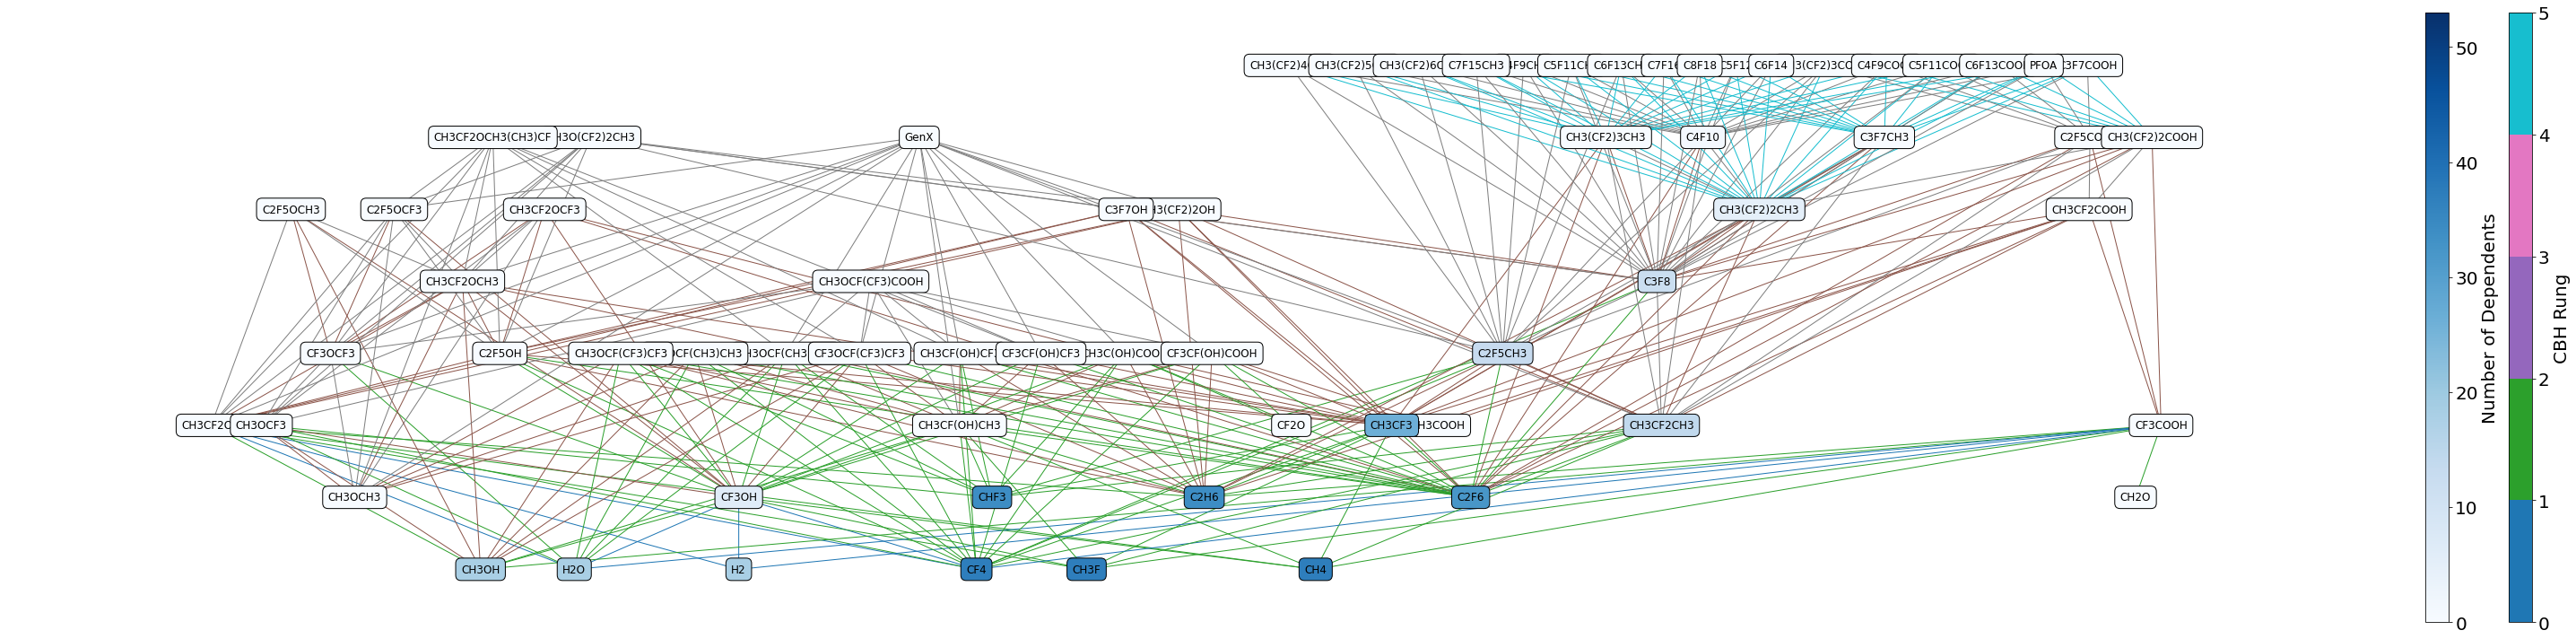

In [41]:
tn.visualize(relabel_node_mapping='../data/alias_manual_2.yaml', reverse_relabel_node_mapping=True, 
             figsize=(40,10))

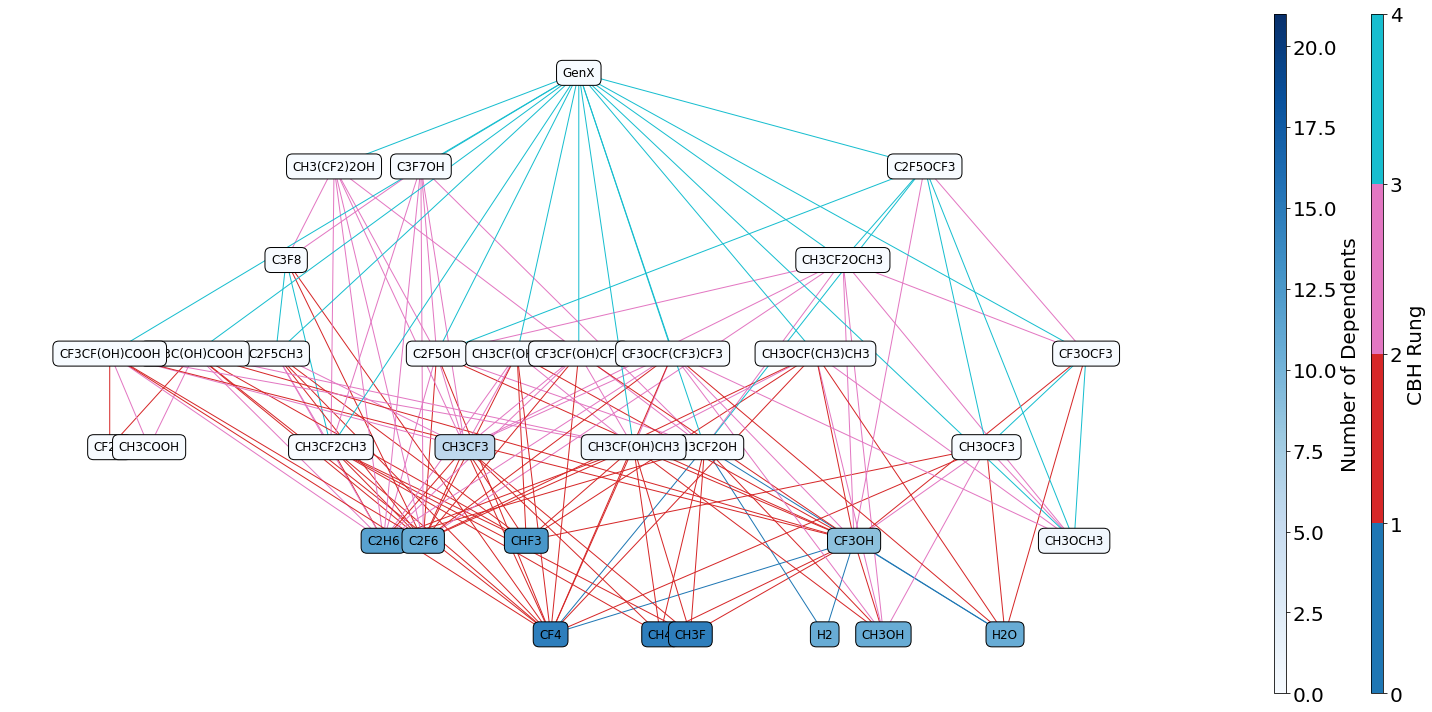

In [42]:
# lets look just at GenX subgraph!
genx = 'O=C(O)C(F)(OC(F)(F)C(F)(F)C(F)(F)(F))C(F)(F)(F)'
genx = Chem.CanonSmiles(genx)
visualize(tn.descendent_subgraph_of(genx), 
          relabel_node_mapping='../data/alias_manual_2.yaml', 
          reverse_relabel_node_mapping=True, 
          figsize=(20,10))

# Uncertainty Quantification

$\texttt{uncertainty\_quantification}$ class is used to track uncertainty propagation. 

This first runs calcCBH internally (so it takes the same arguments), then using the computed 'source' column, it computes the heats of formation again using different intial points in a vectorized manner. Currently cannot use alternative reactions.

Results are stored in $\texttt{simulation\_results}$ attribute.

### Initialize uncertainty quantification class

In [43]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")

Loaded database contains 73 species.


### 1) Experimental uncertainty propagation

In [44]:
uq.run()

Process completed with errors in 33 species
These errors are likely to have propagated for the calculation of heats of formation of larger species.
Updating the reference values of species in the database will improve accuracy of heats of formation.
To inspect the errors, run the calcCBH.print_errors() method.


Number of Species: 100%|███████████████████████| 53/53 [00:00<00:00, 259.53it/s]


In [45]:
uq.simulation_results.shape # shape = (num_species, num_simulations+1)
# first column is the mean experimental values

(73, 10001)

In [46]:
# order of species
uq.species

array(['F', 'O', '[H][H]', 'C', 'CF', 'CO', 'FCF', 'C=O', 'FC(F)F',
       'O=C(F)F', 'OC(F)(F)F', 'FC(F)(F)F', 'CC', 'COC', 'CCO', 'CC(=O)O',
       'CC(O)(F)F', 'CC(F)(F)F', 'COC(F)(F)F', 'CCC', 'CCOC', 'CC(C)O',
       'O=C(O)C(F)(F)F', 'OC(F)(F)C(F)(F)F', 'CCC(=O)O',
       'FC(F)(F)C(F)(F)F', 'CC(C)(F)F', 'CC(C)(O)F', 'FC(F)(F)OC(F)(F)F',
       'COC(C)(F)F', 'CC(F)(F)C(=O)O', 'CC(O)(F)C(=O)O',
       'CC(F)(F)C(F)(F)F', 'CC(F)(F)C(O)(F)F', 'CC(O)(F)C(F)(F)F',
       'CC(F)(F)OC(F)(F)F', 'COC(F)(F)C(F)(F)F', 'COC(C)(C)F',
       'O=C(O)C(F)(F)C(F)(F)F', 'O=C(O)C(O)(F)C(F)(F)F',
       'FC(F)(F)C(F)(F)C(F)(F)F', 'OC(F)(F)C(F)(F)C(F)(F)F',
       'OC(F)(C(F)(F)F)C(F)(F)F', 'CC(F)(F)C(C)(F)F',
       'FC(F)(F)OC(F)(F)C(F)(F)F', 'CC(C)(F)OC(F)(F)F',
       'COC(F)(F)C(C)(F)F', 'CC(F)(F)C(F)(F)C(=O)O',
       'COC(F)(C(=O)O)C(F)(F)F', 'CC(F)(F)C(F)(F)C(F)(F)F',
       'COC(F)(C(F)(F)F)C(F)(F)F', 'CC(C)(F)OC(C)(F)F',
       'O=C(O)C(F)(F)C(F)(F)C(F)(F)F', 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F

In [47]:
import matplotlib.pyplot as plt
import yaml

#### example of how to visualize this

In [48]:
normalized_simresults = uq.simulation_results - np.expand_dims(uq.simulation_results.mean(axis=1), axis=-1)
df = pd.DataFrame(normalized_simresults, index=uq.species)
df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
F,-0.000089,-0.001487,0.015254,-0.003206,0.008987,-0.009796,0.012433,-0.001510,0.003498,-0.015371,...,0.004895,-0.001809,0.021295,0.005473,0.002544,0.009452,-0.006897,0.003790,0.001817,-0.003931
O,0.000125,-0.001936,0.000955,-0.010332,0.005301,-0.020677,-0.007281,-0.010051,-0.006033,-0.000525,...,0.006213,-0.011300,0.015439,-0.009745,0.010140,-0.003050,0.014862,0.001170,-0.006439,0.005545
[H][H],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
C,-0.000322,0.027046,-0.028215,-0.020524,-0.003036,-0.001641,-0.000999,-0.016240,-0.026898,0.064194,...,0.001215,0.015293,0.019355,-0.030133,0.001709,-0.026986,0.004146,0.005728,0.000145,-0.022820
CF,0.001247,-0.220636,0.064097,-0.134448,-0.011962,0.120539,-0.152079,-0.023182,0.193359,0.134882,...,-0.017591,-0.017914,-0.147796,-0.059210,-0.068446,0.161788,-0.038268,0.068637,0.095364,-0.086066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.036627,2.434874,-0.731918,1.322207,-5.309245,-1.102662,4.095170,0.787982,-1.482744,3.789872,...,-1.950842,1.786522,-1.091039,-0.773369,-1.407071,-5.390041,1.071654,5.755374,1.117767,3.771668
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(C)(F)F,-0.037239,2.223274,-0.737949,1.133339,-5.720365,-0.938035,3.880532,0.904626,-1.205186,4.118307,...,-2.419920,1.891914,-1.034096,-0.749606,-1.319977,-5.371455,1.340693,6.197972,1.068728,3.769776
CC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.041022,2.475588,-0.751221,1.271361,-5.903676,-1.125853,4.253438,0.883950,-1.324068,4.279079,...,-2.407335,1.982844,-1.155258,-0.807452,-1.608203,-5.876709,1.398624,6.405142,1.159150,4.068142
O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,-0.053523,2.234537,-0.320370,0.782090,-6.126447,-1.124748,4.135086,0.889228,-0.533942,4.745737,...,-3.414182,2.382064,-1.746499,-0.553402,-2.874821,-6.802150,2.387472,7.026109,0.901117,4.124350


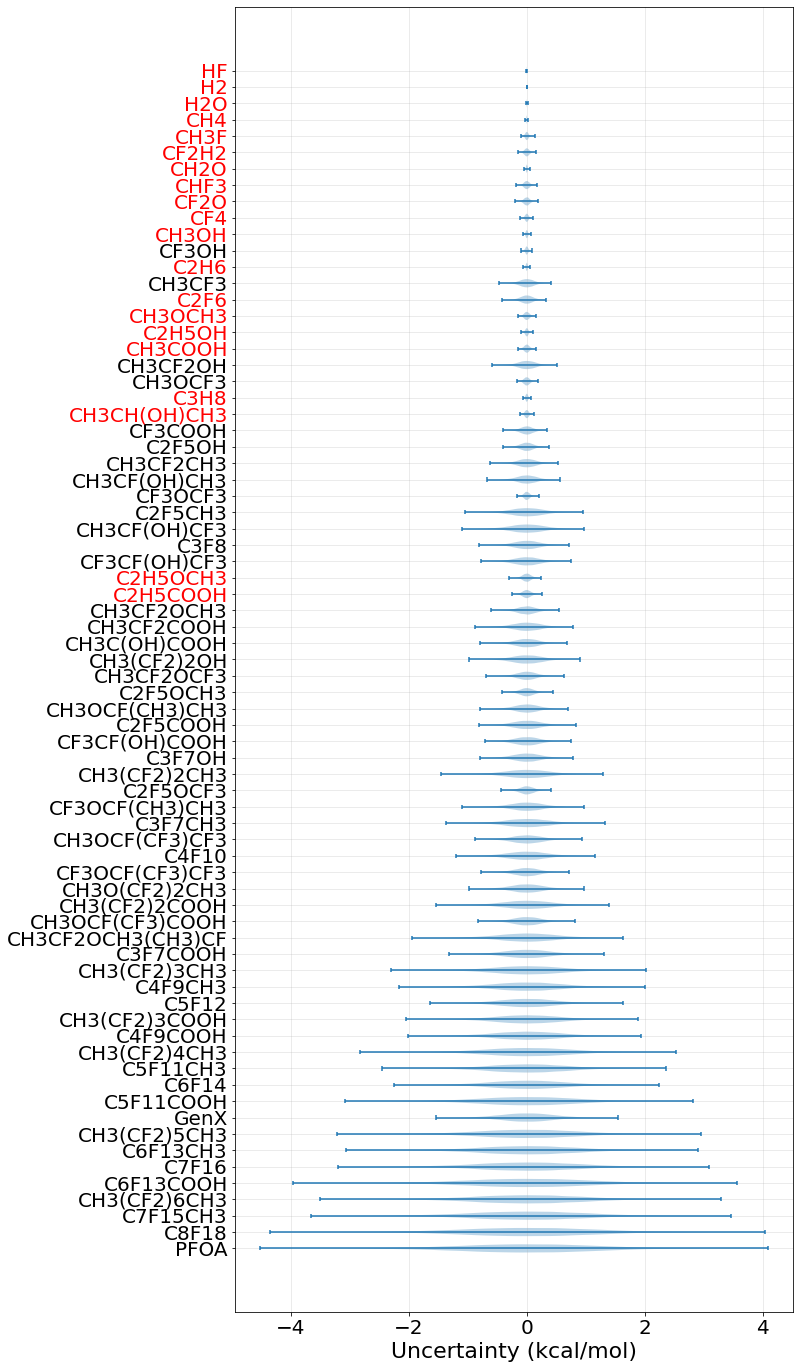

In [49]:
# load name mapping from SMILES
with open('../data/alias_manual_2.yaml', 'r') as f:
    alias = yaml.safe_load(f)
alias_rev = {v:k for k, v in alias.items()}

# generate indices by sorting by SMILES
sorted_inds = sorted(df.index.values, key=uq.simple_sort)[::-1]
alias_sorted_names = [alias_rev[s] for s in sorted_inds]

# find the experimental smiles strings --> to make them red
exp_smiles = [s for s in uq.species if len(uq.calcCBH.energies.loc[s,'source'].split('//'))==1]

# plot uncertainty
fig, ax = plt.subplots(1,1, figsize=(10,24))
ax.violinplot(df.loc[sorted_inds].T/4.184, vert=False)
ax.set_yticks(ticks=np.arange(len(alias_sorted_names))+1, labels=alias_sorted_names, fontsize=20)
plt.xticks(fontsize=20)
for s in exp_smiles:
    if alias_rev[s] in alias_sorted_names:
        ind = alias_sorted_names.index(alias_rev[s])
        ax.get_yticklabels()[ind].set_color("red")
plt.grid(True, axis='both', alpha=0.3)
plt.xlabel('Uncertainty (kcal/mol)', fontsize=22)
plt.show()

### 2) UQ for different CBH selection options (alternative rxns, rel/abs coeff)
Includes experimental uncertainty

In [50]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")

Loaded database contains 73 species.


In [51]:
# This will look at priority protocol
uq.run_cbh_selection() # no arguments --> all combinations of alt rxn options and priority protocol

alt rxn option: include | priority: rung: : 12it [00:48,  4.04s/it]     


[('ignore', 'abs_coeff'),
 ('ignore', 'rel_coeff'),
 ('ignore', 'rung'),
 ('best_alt', 'abs_coeff'),
 ('best_alt', 'rel_coeff'),
 ('best_alt', 'rung'),
 ('avg_alt', 'abs_coeff'),
 ('avg_alt', 'rel_coeff'),
 ('avg_alt', 'rung'),
 ('include', 'abs_coeff'),
 ('include', 'rel_coeff'),
 ('include', 'rung')]

In [52]:
uq.cbh_selection_combos

[('ignore', 'abs_coeff'),
 ('ignore', 'rel_coeff'),
 ('ignore', 'rung'),
 ('best_alt', 'abs_coeff'),
 ('best_alt', 'rel_coeff'),
 ('best_alt', 'rung'),
 ('avg_alt', 'abs_coeff'),
 ('avg_alt', 'rel_coeff'),
 ('avg_alt', 'rung'),
 ('include', 'abs_coeff'),
 ('include', 'rel_coeff'),
 ('include', 'rung')]

In [53]:
uq.simulation_results.shape # ( each combination (order above cell output or uq.cbh_selection_combos), species, num simulations )


(12, 73, 10001)

### 3) UQ for experimental uncertainty and effect of saturation atoms given: CBH selection, and reaction priority

In [54]:
uq = uncertainty_quantification(10000, # number of simulations --> number of random points within exp uncertainty
                                dataframe_path='../data/pfas_energies.pkl', 
                                saturate=[1,9], 
                                method_keys_path='../data/methods_keys.yaml', 
                                rankings_path='../data/rankings.yaml',
                                alternative_rxn_path='../data/alternative_rxn_v5.yaml',
                                priority='rel_coeff', 
                                alt_rxn_option="ignore")
uq.run_cbh_sat(sat_list=[1,9])

Loaded database contains 73 species.


Saturation: [1, 9]: : 3it [00:09,  3.08s/it]


[[1], [9], [1, 9]]

In [55]:
uq.simulation_results.shape # (each saturation combination, species, num simualtions)

(3, 73, 10001)

In [56]:
uq.cbh_sat_combos

[[1], [9], [1, 9]]